In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
# Critic model configuration
clipping_param = 0.01

# Training configuration
device = torch.device("cuda:0")
batch_size = 32
real_label = -1.0
fake_label = 1.0
n_epochs = 100
n_critic = 5

# Dataset configuration
image_size = 28
num_workers = 16

In [3]:
# Clip kernel weights between 
class ConstrainedConv2d(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(
            input,
            self.weight.clamp(min=-clipping_param, max=clipping_param),
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups
        )

In [4]:
def weight_init_critic(m):
    if isinstance(m, ConstrainedConv2d):
        nn.init.normal_(m.weight, 0.0, 0.02)

In [5]:
class Critic(nn.Module):
    def __init__(self, in_shape=(28, 28, 1)) -> None:
        super(Critic, self).__init__()
        # input_shape = 28
        self.input_shape = in_shape[0]
        self.main = nn.Sequential(
            # input: 28 x 28
            ConstrainedConv2d(1, 1, 4, stride=2, padding=1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2),
            # input: 14 x 14
            ConstrainedConv2d(1, 1, 4, stride=2, padding=1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2),
            # output: 7 x 7
            nn.Flatten(),
            nn.Linear(
                self.input_shape // 4 * self.input_shape // 4,
                1
            )
        )
    
    def forward(self, input):
        return self.main(input)

In [6]:
critic_model = Critic().to(device)
critic_model.apply(weight_init_critic)

Critic(
  (main): Sequential(
    (0): ConstrainedConv2d(1, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConstrainedConv2d(1, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=49, out_features=1, bias=True)
  )
)

In [7]:
def weight_init_generator(m):
    if (
        isinstance(m, nn.Linear) or
        isinstance(m, nn.ConvTranspose2d) or
        isinstance(m, nn.Conv2d)
    ):
        nn.init.normal_(m.weight, 0.0, 0.02)

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim) -> None:
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        # Lay foundation for 7 x 7 image with 128 channels
        n_nodes = 128 * 7 * 7
        self.main = nn.Sequential(
            nn.Linear(latent_dim, n_nodes),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, 7, 7)),
            # input: 7 x 7
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # input: 14 x 14
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(0.2),
            # input: 28 x 28
            nn.Conv2d(1, 1, 7, padding="same"),
            nn.Tanh()
            # output: 28 x 28
        )
    
    def forward(self, input):
        return self.main(input)

In [9]:
generator_model = Generator(50).to(device)
generator_model.apply(weight_init_generator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=50, out_features=6272, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Unflatten(dim=1, unflattened_size=(128, 7, 7))
    (3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (10): Tanh()
  )
)

In [10]:
dataset = torchvision.datasets.MNIST(
    root="mnist_root_dir",
    download=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ])
)
filter_digit = 7
idx = dataset.targets == filter_digit
dataset.targets = dataset.targets[idx]
dataset.data = dataset.data[idx]
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

(-0.5, 27.5, 27.5, -0.5)

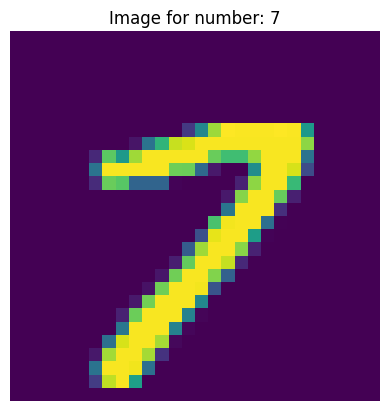

In [11]:
dummy_batch = next(iter(dataloader))
plt.imshow(dummy_batch[0][23][0])
plt.title(f"Image for number: {dummy_batch[1][23]}")
plt.axis("off")

In [12]:
optimizer_critic = optim.RMSprop(critic_model.parameters(), lr=5e-5)
optimizer_generator = optim.RMSprop(generator_model.parameters(), lr=5e-5)

In [13]:
def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)

In [ ]:
# Training loop
print("Starting training....")
c1_hist = list()
c2_hist = list()
g_hist  = list()
print(f"Number of mini batch iterations per epoch: {len(dataloader)}")
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(dataloader, 0)):
        c1_loss = list()
        c2_loss = list()
        for _ in range(n_critic):
            real_batch = data[0].to(device)
            b_size = real_batch.shape[0]

            # Update critic weight for real images
            critic_model.zero_grad()
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output = critic_model(real_batch)
            loss = wasserstein_loss(label, output)
            loss.backward()
            c1_loss.append(loss.detach().cpu())
            optimizer_critic.step()

            # Update critic weight for fake images
            critic_model.zero_grad()
            noise = torch.randn(b_size, 50, device=device)
            fake_batch = generator_model(noise)
            label.fill_(fake_label)
            output = critic_model(fake_batch)
            loss = wasserstein_loss(label, output)
            loss.backward()
            c2_loss.append(loss.detach().cpu())
            optimizer_critic.step()

        c1_hist.append(np.mean(c1_loss))
        c2_hist.append(np.mean(c2_loss))
        # Update generator weight
        generator_model.zero_grad()
        critic_model.zero_grad()
        noise = torch.randn(2 * b_size, 50, device=device)
        fake_batch = generator_model(noise)
        label.fill_(real_label)
        output = critic_model(fake_batch)
        loss = wasserstein_loss(label, output)
        loss.backward()
        g_hist.append(loss.detach().cpu())
        optimizer_generator.step()

    # Summarize performance every epoch
    if not epoch % 1:
        tqdm.write("".join((
            f"epoch: {epoch}, c1 loss: {c1_hist[-1]:.4f}, ",
            f"c2 loss: {c2_hist[-1]:.4f}, g loss: {g_hist[-1]:.4f}"
        )))

In [ ]:
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	plt.plot(d1_hist, label='crit_real')
	plt.plot(d2_hist, label='crit_fake')
	plt.plot(g_hist, label='gen')
	plt.legend()
	plt.savefig('plot_line_plot_loss.png')
	plt.close()

In [ ]:
plot_history(c1_hist, c2_hist, g_hist)